In [4]:
import numpy as np
import cfgrib
import xarray as xr
#import xesmf as xe

import xarray as xr
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime
import pandas as pd
import geopandas as gp
import collections

from typing import Dict
from climate_indices.indices import spi, Distribution
from climate_indices.compute import Periodicity


/opt/conda/lib/python3.10/site-packages/climate_indices/utils.py:149: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def reshape_to_2d(
/opt/conda/lib/python3.10/site-packages/climate_indices/utils.py:199: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def reshape_to_divs_years_months(
/opt/conda/lib/python3.10/site-packages/climate_indices/utils.py:248: NumbaDepr

## CHRIPS data processing, regrrdding the CHRIPS data to 25km to match with SEAS5, regridded 25km data
1. see the mam_spi_kmj_probability.ipynb for seas5 regridding method

In [ ]:
import xarray as xr
import numpy as np
import xesmf as xe

db=xr.open_dataset('/home/chirps-v2.0.monthly.nc')
min_lon = 29.0
min_lat = -2.0-0.5
max_lon = 35.0+0.5
max_lat = 4.2+0.5
ea_db = db.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))
local_path_nc=f'/home/kmj_chirps-v2.0.monthly.nc'
ea_db.to_netcdf(local_path_nc)
ds=xr.open_dataset('/home/kmj_chirps-v2.0.monthly.nc')
ds1=ds.rename({'longitude':'lon','latitude':'lat'})
dr = ds1["precip"] 
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-2, 5.25, 0.25), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(29, 38.25, 0.25), {"units": "degrees_east"}),
    }
)
regridder = xe.Regridder(ds1, ds_out, "bilinear")
regridder  # print basic regridder information.
dr_out = regridder(dr, keep_attrs=True)
ds2=dr_out.to_dataset()
ds2.to_netcdf('/home/kmj_km25_chirps-v2.0.monthly.nc')

## SPI calculation method

In [5]:
# based on https://gist.github.com/monocongo/978348233b4bde80e9bcc52fe8e4150c


# create a wrapper function that can be applied to an entire Dataset
# (takes a DataArray as first argument, returns a DataArray)
def spi_wrapper(
    obj: xr.DataArray,
    precip_var: str,
    scale: int,
    distribution: Distribution,
    data_start_year: int,
    calibration_year_initial: int,
    calibration_year_final: int,
    periodicity: Periodicity,
    fitting_params: Dict = None,
) -> xr.DataArray:
    
    # compute SPI for this timeseries
    spi_data = spi(
        values=obj[precip_var].to_numpy(), #TODO find why we need to use the variable name rather than already using the variables's DataArray (i.e. why is obj a Dataset?)
        scale=scale,
        distribution=distribution,
        data_start_year=data_start_year,
        calibration_year_initial=calibration_year_initial,
        calibration_year_final=calibration_year_final,
        periodicity=periodicity,
        fitting_params=fitting_params,
    )
    #TODO for some reason this is necessary for the nClimGrid low-resolution example NetCDFs
    #TODO find out why
    spi_data = spi_data.flatten()
    #TODO for some reason this is necessary for the NCO-modified nClimGrid normal-resolution example NetCDFs
    #TODO find out why
    #spi_data = spi_data.reshape(spi_data.size, 1)
    # create the return DataArray (copy of input object's geospatial dims/coords plus SPI data)
    da_spi = xr.DataArray(
        dims   = obj[precip_var].dims,
        coords = obj[precip_var].coords,
        attrs  = {
            'description': 'SPI computed by the climate_indices Python package',
            'references': 'https://github.com/monocongo/climate_indices',
            'valid_min': -3.09, # this should mirror climate_indices.indices._FITTED_INDEX_VALID_MIN
            'valid_max':  3.09, # this should mirror climate_indices.indices._FITTED_INDEX_VALID_MAX
        },
        data = spi_data,
    )

    return da_spi

In [20]:
def det_cat_fct_init(thr, axis=None):
    """
    Initialize a contingency table object.
    Parameters
    ----------
    thr: float
        threshold that is applied to predictions and observations in order
        to define events vs no events (yes/no).
    axis: None or int or tuple of ints, optional
        Axis or axes along which a score is integrated. The default, axis=None,
        will integrate all of the elements of the input arrays.\n
        If axis is -1 (or any negative integer),
        the integration is not performed
        and scores are computed on all of the elements in the input arrays.\n
        If axis is a tuple of ints, the integration is performed on all of the
        axes specified in the tuple.
    Returns
    -------
    out: dict
      The contingency table object.
    """
    contab = {}
    # catch case of axis passed as integer
    def get_iterable(x):
        if x is None or (
            isinstance(x, collections.abc.Iterable) and not isinstance(x, int)
        ):
            return x
        else:
            return (x,)
    contab["thr"] = thr
    contab["axis"] = get_iterable(axis)
    contab["hits"] = None
    contab["false_alarms"] = None
    contab["misses"] = None
    contab["correct_negatives"] = None
    return contab


def det_cat_fct_accum(contab, pred, obs):
    """
    https://github.com/pySTEPS/pysteps/blob/master/pysteps/verification/detcatscores.py
    Accumulate the frequency of "yes" and "no" forecasts and observations
    in the contingency table.
    Parameters
    ----------
    contab: dict
      A contingency table object initialized with
      pysteps.verification.detcatscores.det_cat_fct_init.
    pred: array_like
        Array of predictions. NaNs are ignored.
    obs: array_like
        Array of verifying observations. NaNs are ignored.
    """
    pred = np.asarray(pred.copy())
    obs = np.asarray(obs.copy())
    axis = tuple(range(pred.ndim)) if contab["axis"] is None else contab["axis"]
    # checks
    if pred.shape != obs.shape:
        raise ValueError(
            "the shape of pred does not match the shape of obs %s!=%s"
            % (pred.shape, obs.shape)
        )
    if pred.ndim <= np.max(axis):
        raise ValueError(
            "axis %d is out of bounds for array of dimension %d"
            % (np.max(axis), len(pred.shape))
        )
    idims = [dim not in axis for dim in range(pred.ndim)]
    nshape = tuple(np.array(pred.shape)[np.array(idims)])
    if contab["hits"] is None:
        # initialize the count arrays in the contingency table
        contab["hits"] = np.zeros(nshape, dtype=int)
        contab["false_alarms"] = np.zeros(nshape, dtype=int)
        contab["misses"] = np.zeros(nshape, dtype=int)
        contab["correct_negatives"] = np.zeros(nshape, dtype=int)
    else:
        # check dimensions
        if contab["hits"].shape != nshape:
            raise ValueError(
                "the shape of the input arrays does not match "
                + "the shape of the "
                + "contingency table %s!=%s" % (nshape, contab["hits"].shape)
            )
    # add dummy axis in case integration is not required
    if np.max(axis) < 0:
        pred = pred[None, :]
        obs = obs[None, :]
        axis = (0,)
    axis = tuple([a for a in axis if a >= 0])
    # apply threshold
    predb = pred > contab["thr"]
    obsb = obs > contab["thr"]
    # calculate hits, misses, false positives, correct rejects
    H_idx = np.logical_and(predb == 1, obsb == 1)
    F_idx = np.logical_and(predb == 1, obsb == 0)
    M_idx = np.logical_and(predb == 0, obsb == 1)
    R_idx = np.logical_and(predb == 0, obsb == 0)
    # accumulate in the contingency table
    contab["hits"] += np.nansum(H_idx.astype(int), axis=axis)
    contab["misses"] += np.nansum(M_idx.astype(int), axis=axis)
    contab["false_alarms"] += np.nansum(F_idx.astype(int), axis=axis)
    contab["correct_negatives"] += np.nansum(R_idx.astype(int), axis=axis)
    return contab

    
def get_iterable(x):
        if isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
            return x
        else:
            return (x,)    

    
def det_cat_fct_compute(contab, scores=""):
    """
    https://github.com/pySTEPS/pysteps/blob/master/pysteps/verification/detcatscores.py
    Compute simple and skill scores for deterministic categorical
    (dichotomous) forecasts from a contingency table object.
    Parameters
    ----------
    contab: dict
      A contingency table object initialized with
      pysteps.verification.detcatscores.det_cat_fct_init and populated with
      pysteps.verification.detcatscores.det_cat_fct_accum.
    scores: {string, list of strings}, optional
        The name(s) of the scores. The default, scores="", will compute all
        available scores.
        The available score names a
        .. tabularcolumns:: |p{2cm}|L|
        +------------+--------------------------------------------------------+
        | Name       | Description                                            |
        +============+========================================================+
        |  ACC       | accuracy (proportion correct)                          |
        +------------+--------------------------------------------------------+
        |  BIAS      | frequency bias                                         |
        +------------+--------------------------------------------------------+
        |  CSI       | critical success index (threat score)                  |
        +------------+--------------------------------------------------------+
        |  ETS       | equitable threat score                                 |
        +------------+--------------------------------------------------------+
        |  F1        | the harmonic mean of precision and sensitivity         |
        +------------+--------------------------------------------------------+
        |  FA        | false alarm rate (prob. of false detection, fall-out,  |
        |            | false positive rate)                                   |
        +------------+--------------------------------------------------------+
        |  FAR       | false alarm ratio (false discovery rate)               |
        +------------+--------------------------------------------------------+
        |  GSS       | Gilbert skill score (equitable threat score)           |
        +------------+--------------------------------------------------------+
        |  HK        | Hanssen-Kuipers discriminant (Pierce skill score)      |
        +------------+--------------------------------------------------------+
        |  HSS       | Heidke skill score                                     |
        +------------+--------------------------------------------------------+
        |  MCC       | Matthews correlation coefficient                       |
        +------------+--------------------------------------------------------+
        |  POD       | probability of detection (hit rate, sensitivity,       |
        |            | recall, true positive rate)                            |
        +------------+--------------------------------------------------------+
        |  SEDI      | symmetric extremal dependency index                    |
        +------------+--------------------------------------------------------+
    Returns
    -------
    result: dict
        Dictionary containing the verification results.
    """
    # catch case of single score passed as string
    scores = get_iterable(scores)
    H = 1.0 * contab["hits"]  # true positives
    M = 1.0 * contab["misses"]  # false negatives
    F = 1.0 * contab["false_alarms"]  # false positives
    R = 1.0 * contab["correct_negatives"]  # true negatives
    result = {}
    for score in scores:
        # catch None passed as score
        if score is None:
            continue
        score_ = score.lower()
        # simple scores
        POD = H / (H + M)
        FAR = F / (H + F)
        FA = F / (F + R)
        s = (H + M) / (H + M + F + R)
        if score_ in ["pod", ""]:
            # probability of detection
            result["POD"] = POD
        if score_ in ["far", ""]:
            # false alarm ratio
            result["FAR"] = FAR
        if score_ in ["fa", ""]:
            # false alarm rate (prob of false detection)
            result["FA"] = FA
        if score_ in ["acc", ""]:
            # accuracy (fraction correct)
            ACC = (H + R) / (H + M + F + R)
            result["ACC"] = ACC
        if score_ in ["csi", ""]:
            # critical success index
            CSI = H / (H + M + F)
            result["CSI"] = CSI
        if score_ in ["bias", ""]:
            # frequency bias
            B = (H + F) / (H + M)
            result["BIAS"] = B
        # skill scores
        if score_ in ["hss", ""]:
            # Heidke Skill Score (-1 < HSS < 1) < 0 implies no skill
            HSS = 2 * (H * R - F * M) / ((H + M) * (M + R) + (H + F) * (F + R))
            result["HSS"] = HSS
        if score_ in ["hk", ""]:
            # Hanssen-Kuipers Discriminant
            HK = POD - FA
            result["HK"] = HK
        if score_ in ["gss", "ets", ""]:
            # Gilbert Skill Score
            GSS = (POD - FA) / ((1 - s * POD) / (1 - s) + FA * (1 - s) / s)
            if score_ == "ets":
                result["ETS"] = GSS
            else:
                result["GSS"] = GSS
        if score_ in ["sedi", ""]:
            # Symmetric extremal dependence index
            SEDI = (np.log(FA) - np.log(POD) + np.log(1 - POD) - np.log(1 - FA)) / (
                np.log(FA) + np.log(POD) + np.log(1 - POD) + np.log(1 - FA)
            )
            result["SEDI"] = SEDI
        if score_ in ["mcc", ""]:
            # Matthews correlation coefficient
            MCC = (H * R - F * M) / np.sqrt((H + F) * (H + M) * (R + F) * (R + M))
            result["MCC"] = MCC
        if score_ in ["f1", ""]:
            # F1 score
            F1 = 2 * H / (2 * H + F + M)
            result["F1"] = F1
    return result

## CHRIPS data processing

In [6]:
cdb=xr.open_dataset('/home/kmj_km25_chirps-v2.0.monthly.nc')
cdb_sc = cdb.stack(grid_cells=('lat', 'lon',))

spi_cdb = cdb_sc.groupby('grid_cells').apply(
    spi_wrapper,
    precip_var='precip',
    scale=3,
    distribution=Distribution.gamma,
    data_start_year=1981,
    calibration_year_initial=1981,
    calibration_year_final=2018,
    periodicity=Periodicity.monthly,
).unstack('grid_cells')

spi_cdb1=spi_cdb.to_dataset(name='spi')


In [8]:
kp=gp.read_file('/home/kmj_points.shp')
kp['lon'] = kp.geometry.x
kp1=kp.drop_duplicates('lon')
kp2=kp1.sort_values('lon')
kp2_lon=kp2['lon'].tolist()
kp['lat'] = kp.geometry.y
kp1=kp.drop_duplicates('lat')
kp2=kp1.sort_values('lat')
kp2_lat=kp2['lat'].tolist()


#lon_list=list(set(kp['lon'].tolist())).sort()
#lat_list=list(set(kp['lat'].tolist())).sort()


xda = xr.DataArray(kp2_lon, dims=['z'])
yda = xr.DataArray(kp2_lat, dims=['z'])

#aa1=aa.sel(:,lat=yda, lon=xda)
#aa1
#LatIndexer, LonIndexer = 'lat', 'lon'
#aa1 = aa.sel(**{LatIndexer: slice(4.25, 1.5),
#                        LonIndexer: slice(35.0, 33.5)})

#LatIndexer, LonIndexer = 'lat', 'lon'
#SliceData = aa.loc[{LatIndexer: slice(4.25, 1.5),
#                      LonIndexer: slice(35.0, 33.5)}]
#aa

#spi_ds_ens_kmj = spi_ds_ens.sel(lat=slice(min(kp2_lat),max(kp2_lat)), lon=slice(min(kp2_lon),max(kp2_lon)))
#spi_ds_ens_kmj_st=spi_ds_ens_kmj.sel(time='1993-05-01T00:00:00.000000000')

In [33]:

ds_chr=spi_cdb1

db=pd.DataFrame()
db['dt']=ds_chr['time'].values
db['month']=db['dt'].dt.strftime('%b').astype(str).str[0]
db['year']=db['dt'].dt.strftime('%Y')
db['spi_prod'] = db.groupby('year')['month'].shift(2)+db.groupby('year')['month'].shift(1) + db.groupby('year')['month'].shift(0)
spi_prod_list=db['spi_prod'].tolist()
#spi_prod_list

ds_chr1 = ds_chr.assign_coords(spi_prod=('time',spi_prod_list))
#ds_ens2=ds_ens[ds_ens['spi_prod']=='MAM']
#db1_m1=ds_ens1.sel(spi_prod='MAM')

chr_mam=ds_chr1.where(ds_chr1.spi_prod=='MAM', drop=True)


xda = xr.DataArray(kp2_lon, dims=['z'])
yda = xr.DataArray(kp2_lat, dims=['z'])

chr_mam1 = chr_mam.sel(lat=slice(min(kp2_lat),max(kp2_lat)), lon=slice(min(kp2_lon),max(kp2_lon)))
chr_mam2=chr_mam1.where(chr_mam1['time.year'] >= 1993, drop=True)
#chr_mam3=chr_mam2.to_array().values.ravel()
#chr_mam3

chr_mam3 = chr_mam2.reset_coords(drop=True).to_dataframe()
chr_mam4=chr_mam3.reset_index()
chr_mam5 = chr_mam4.groupby(['time'])['spi'].mean().reset_index()
chr_mam6=chr_mam5['spi'].tolist()

In [25]:
chr_mam2

<xarray.Dataset>
Dimensions:   (time: 30, lat: 12, lon: 7)
Coordinates:
  * lat       (lat) float64 1.5 1.75 2.0 2.25 2.5 ... 3.25 3.5 3.75 4.0 4.25
  * lon       (lon) float64 33.5 33.75 34.0 34.25 34.5 34.75 35.0
  * time      (time) datetime64[ns] 1993-05-01 1994-05-01 ... 2022-05-01
    spi_prod  (time) <U32 'MAM' 'MAM' 'MAM' 'MAM' ... 'MAM' 'MAM' 'MAM' 'MAM'
Data variables:
    spi       (time, lat, lon) float64 -0.2895 -1.531 -2.198 ... -0.1635 0.0567

## JAN for MAM SEA5 data processing 

In [10]:
dates = pd.date_range('1993-01-01', '2022-10-01', freq='MS')
#db=pd.DataFrame(dates)
#db.columns=['years']
#db1=db.set_index('years')
#db1[db1.index.month.isin([12])]

jan_dates=dates[dates.month.isin([1])]
jd1=jan_dates.strftime('%Y-%m-%dT00:00:00.000000000')

#month_list=['month1','month2','month3','month4','month5','month6']


#for month in month_list:
#jan_dates=dates[dates.month.isin([1])]
#jd1=jan_dates.strftime('%Y-%m-%dT00:00:00.000000000')


cont_mdb=[]
for jd in jd1:
    db_m1=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth1_km25_seas5_mem51.nc')
    db1_m1=db_m1.sel(time=jd)
    db_m2=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth2_km25_seas5_mem51.nc')
    db1_m2=db_m2.sel(time=jd)
    db_m3=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth3_km25_seas5_mem51.nc')
    db1_m3=db_m3.sel(time=jd)
    db_m4=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth4_km25_seas5_mem51.nc')
    db1_m4=db_m4.sel(time=jd)
    db_m5=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth5_km25_seas5_mem51.nc')
    db1_m5=db_m5.sel(time=jd)
    db_m6=xr.open_dataset('/home/kmj_seas5/tp_kmj_ltmonth6_km25_seas5_mem51.nc')
    db1_m6=db_m6.sel(time=jd)
    db1_m=xr.concat([db1_m1,db1_m2,db1_m3,db1_m4,db1_m5,db1_m6],dim='time')
    cont_mdb.append(db1_m)
    
    
erf1=xr.concat(cont_mdb,dim='time')
#erf['time'].values[4],erf['valid_time'].values[4]
#erf['valid_time'].values
#erf1=erf.rename({'time': 'old_time','valid_time': 'time'})
#erf2=erf1.drop("time")
#erf2.assign_coords({"time": erf2.valid_time.values})
#erf1['time'].values
#erf3 = erf2.expand_dims(time=erf2.valid_time.values)
#erf3['time'].values
erf1 = erf1.assign_coords(time=('time',erf1.valid_time.values))
#erf1['time'].values

erf1.to_netcdf('/home/kmj_seas5/trail3/jan_1993.nc')



### create SPI_MAM for Jan

In [12]:
#import xarray as xr

sdb=xr.open_dataset('/home/kmj_seas5/trail3/jan_1993.nc')

#sdb=erf1

member_list=np.arange(0,51,1)


for meml in member_list:
    #sdb1=sdb['tprate'][meml]
    #sdb2=sdb1.to_dataset(name='tprate')
    sdb1=sdb.sel(number=meml)
    #sdb2
    sc = sdb1.stack(grid_cells=('lat', 'lon',))
    spi_ds = sc.groupby('grid_cells').apply(
        spi_wrapper,
        precip_var='tprate',
        scale=3,
        distribution=Distribution.gamma,
        data_start_year=1993,
        calibration_year_initial=1993,
        calibration_year_final=2018,
        periodicity=Periodicity.monthly).unstack('grid_cells')
    spi_ds1=spi_ds.to_dataset(name='tprate')
    #spi_ds2=spi_ds1.to_dataframe()
    #db3=db2.reset_index()
    #spi_ds3=spi_ds2.reset_index()
    output_path='/home/kmj_seas5/trail3/spi_jan_1993_3/'
    #spi_ds2.to_csv(f'{output_path}month6_{meml}.csv')
    spi_ds1.to_netcdf(f'{output_path}jan_{meml}.nc')
    sdb1=[]
    sdb2=[]
    sc=[]
    spi_ds=[]
    spi_ds1=[]
    spi_ds2=[]
    spi_ds3=[]
    print(meml)
    
    


2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:33 WARNING Input contains negative values -- all neg

2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:34 WARNING Input contains negative values -- all neg

0


2023-05-15  10:20:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:38 WARNING Input contains negative values -- all neg

2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all neg

2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:39 WARNING Input contains negative values -- all neg

1


2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:43 WARNING Input contains negative values -- all neg

2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all neg

2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:44 WARNING Input contains negative values -- all neg

2


2023-05-15  10:20:47 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:47 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:47 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all neg

2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all neg

2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all neg

2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:49 WARNING Input contains negative values -- all neg

3


2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:53 WARNING Input contains negative values -- all neg

2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all neg

2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all neg

2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:55 WARNING Input contains negative values -- all neg

4


2023-05-15  10:20:58 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:58 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:58 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:58 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:58 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all neg

2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:20:59 WARNING Input contains negative values -- all neg

2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:00 WARNING Input contains negative values -- all neg

5


2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:03 WARNING Input contains negative values -- all neg

2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all neg

2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all neg

2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all neg

2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:05 WARNING Input contains negative values -- all neg

6


2023-05-15  10:21:08 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:08 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:08 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:08 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:08 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:08 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:08 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:09 WARNING Input contains negative values -- all neg

2023-05-15  10:21:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:10 WARNING Input contains negative values -- all neg

7


2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:13 WARNING Input contains negative values -- all neg

2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all neg

2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:14 WARNING Input contains negative values -- all neg

2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all neg

2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:15 WARNING Input contains negative values -- all negatives clipped to zero


8


2023-05-15  10:21:18 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:18 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all neg

2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:19 WARNING Input contains negative values -- all neg

2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:20 WARNING Input contains negative values -- all neg

9


2023-05-15  10:21:23 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:23 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:23 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:23 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:23 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:23 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:23 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:23 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:23 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all neg

2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:24 WARNING Input contains negative values -- all neg

10


2023-05-15  10:21:27 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:27 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:28 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:28 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:28 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:28 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:28 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:28 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:28 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:28 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:28 WARNING Input contains negative values -- all neg

2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all neg

2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all neg

2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:29 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:30 WARNING Input contains negative values -- all neg

11


2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:33 WARNING Input contains negative values -- all neg

2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:34 WARNING Input contains negative values -- all neg

12


2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:38 WARNING Input contains negative values -- all neg

2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:39 WARNING Input contains negative values -- all neg

13


2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:43 WARNING Input contains negative values -- all neg

2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all neg

2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:44 WARNING Input contains negative values -- all neg

14


2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:48 WARNING Input contains negative values -- all neg

2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all neg

2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:49 WARNING Input contains negative values -- all neg

15


2023-05-15  10:21:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:53 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all neg

2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:54 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all neg

2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:55 WARNING Input contains negative values -- all neg

16


2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:21:59 WARNING Input contains negative values -- all neg

2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all neg

2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all neg

2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:00 WARNING Input contains negative values -- all neg

17


2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:04 WARNING Input contains negative values -- all neg

2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all neg

2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:05 WARNING Input contains negative values -- all neg

18


2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all neg

2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:09 WARNING Input contains negative values -- all neg

2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all neg

2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all neg

2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:10 WARNING Input contains negative values -- all negatives clipped to zero


19


2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:14 WARNING Input contains negative values -- all neg

2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all neg

2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all neg

2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:15 WARNING Input contains negative values -- all neg

20


2023-05-15  10:22:19 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all neg

2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:20 WARNING Input contains negative values -- all neg

2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all neg

2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:21 WARNING Input contains negative values -- all neg

21


2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:24 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:25 WARNING Input contains negative values -- all neg

2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all neg

2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:26 WARNING Input contains negative values -- all neg

22


2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all neg

2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:30 WARNING Input contains negative values -- all neg

2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:31 WARNING Input contains negative values -- all neg

23


2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:35 WARNING Input contains negative values -- all neg

2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:36 WARNING Input contains negative values -- all neg

2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all negatives clipped to zero
2023-05-15  10:22:37 WARNING Input contains negative values -- all neg

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


### organize SEAS5 SPI into verification format

In [30]:
member_list=np.arange(0,51,1)

mam_ncfl_path='/home/kmj_seas5/trail3/spi_jan_1993_3/'


mem_data_arrays = []
for mem in member_list:
    mem_file_path=f'{mam_ncfl_path}jan_{mem}.nc'
    ds=xr.open_dataset(mem_file_path)
    mem_data_arrays.append(ds)
    ds=[]

ds_ens = xr.concat(mem_data_arrays, dim='ens_mem')    

db=pd.DataFrame()
db['dt']=ds_ens['time'].values
db['month']=db['dt'].dt.strftime('%b').astype(str).str[0]
db['year']=db['dt'].dt.strftime('%Y')
db['spi_prod'] = db.groupby('year')['month'].shift(2)+db.groupby('year')['month'].shift(1) + db.groupby('year')['month'].shift(0)
spi_prod_list=db['spi_prod'].tolist()

#spi_prod_list
# concatenate list of data arrays along new dimension into xarray dataset

ds_ens1 = ds_ens.assign_coords(spi_prod=('time',spi_prod_list))
#ds_ens2=ds_ens[ds_ens['spi_prod']=='MAM']

ens_mam=ds_ens1.where(ds_ens1.spi_prod=='MAM', drop=True)

ens_mam1 = ens_mam.sel(lat=slice(min(kp2_lat),max(kp2_lat)), lon=slice(min(kp2_lon),max(kp2_lon)))
ens_mam2=ens_mam1.groupby('time.year').mean(dim='ens_mem')

#https://stackoverflow.com/questions/59699168/average-a-dimension-of-a-chunk-xarray
#ens_mam3=ens_mam2.to_array().values.ravel()
#ens_mam3

ens_mam4 = ens_mam2.reset_coords(drop=True).to_dataframe()
ens_mam5=ens_mam4.reset_index()
ens_mam6 = ens_mam5.groupby(['time'])['tprate'].mean().reset_index()
ens_mam7=ens_mam6['tprate'].tolist()

In [34]:
athr_mild=-0.03
te_contab_mild=det_cat_fct_init(athr_mild)
te_contab_mild1=det_cat_fct_accum(te_contab_mild, ens_mam7, chr_mam6)
results_mild=det_cat_fct_compute(te_contab_mild1,scores="")

athr_moderate=-0.55
te_contab_moderate=det_cat_fct_init(athr_moderate)
te_contab_moderate1=det_cat_fct_accum(te_contab_moderate, ens_mam7, chr_mam6)
results_moderate=det_cat_fct_compute(te_contab_moderate1,scores="")

athr_severe=-0.99
te_contab_severe=det_cat_fct_init(athr_severe)
te_contab_severe1=det_cat_fct_accum(te_contab_severe, ens_mam7, chr_mam6)
results_severe=det_cat_fct_compute(te_contab_severe1,scores="")

In [35]:
results_mild,results_moderate,results_severe

({'POD': 0.625,
  'FAR': 0.375,
  'FA': 0.42857142857142855,
  'ACC': 0.6,
  'CSI': 0.45454545454545453,
  'BIAS': 1.0,
  'HSS': 0.19642857142857142,
  'HK': 0.19642857142857145,
  'GSS': 0.10891089108910892,
  'SEDI': 0.2794186565089397,
  'MCC': 0.19642857142857142,
  'F1': 0.625},
 {'POD': 0.9545454545454546,
  'FAR': 0.27586206896551724,
  'FA': 1.0,
  'ACC': 0.7,
  'CSI': 0.7,
  'BIAS': 1.3181818181818181,
  'HSS': -0.06299212598425197,
  'HK': -0.045454545454545414,
  'GSS': -0.03053435114503814,
  'SEDI': nan,
  'MCC': -0.11197850219117086,
  'F1': 0.8235294117647058},
 {'POD': 1.0,
  'FAR': 0.1,
  'FA': 1.0,
  'ACC': 0.9,
  'CSI': 0.9,
  'BIAS': 1.1111111111111112,
  'HSS': 0.0,
  'HK': 0.0,
  'GSS': 0.0,
  'SEDI': nan,
  'MCC': nan,
  'F1': 0.9473684210526315})

In [42]:
mild_list=[results_mild['FAR'],results_mild['POD'],results_mild['BIAS'],results_mild['HSS'],results_mild['HK']]
mode_list=[results_moderate['FAR'],results_moderate['POD'],results_moderate['BIAS'],results_moderate['HSS'],results_moderate['HK']]
severe_list=[results_severe['FAR'],results_severe['POD'],results_severe['BIAS'],results_severe['HSS'],results_severe['HK']]

db=pd.DataFrame()

db['moderate']=mild_list
db['extreme']=mode_list
db['severe']=severe_list

db['stat']=['FAR','HR','BIAS','HSS','HK']

db1=db.set_index('stat')
db1

,moderate,extreme,severe
stat,,,
FAR,0.375000,0.275862,0.100000
HR,0.625000,0.954545,1.000000
BIAS,1.000000,1.318182,1.111111
HSS,0.196429,-0.062992,0.000000
HK,0.196429,-0.045455,0.000000


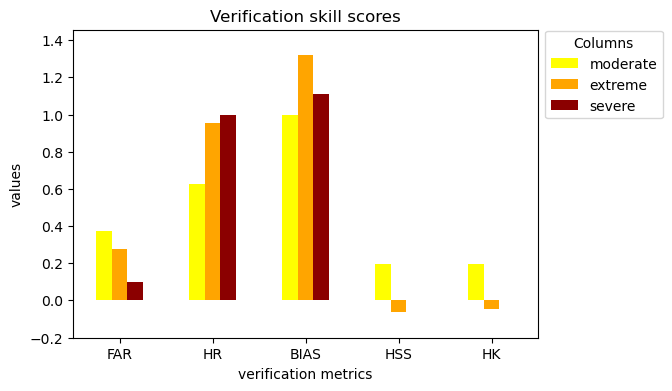

In [44]:
my_colors=['#ffff00','#ffa500','#8b0000']

ax = db1.plot(kind='bar', rot=0, xlabel='verification metrics', ylabel='values', title='Verification skill scores', figsize=(6, 4),color=my_colors)

# add some labels
#for c in ax.containers:
    # set the bar label
#    ax.bar_label(c, fmt='%.0f', label_type='edge')
    
# add a little space at the top of the plot for the annotation
ax.margins(y=0.1)

# move the legend out of the plot
ax.legend(title='Columns', bbox_to_anchor=(1, 1.02), loc='upper left')
